In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


# Data preparation

In [2]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# what data looks like
train.head()


label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         0  
1         0         0         0         0         0  
2         0         0         0         0         0  
3         0         0         0         0         0  
4         0         0         0         0         0  

[5 rows x 785 columns]

In [4]:
Y_train = train['label']
X_train = train.drop(['label'], axis = 1)

In [5]:
# Check null
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
# Normalization 
X_train = X_train / 255
test = test / 255


/Users/haicuthe/anaconda2/envs/dev-env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


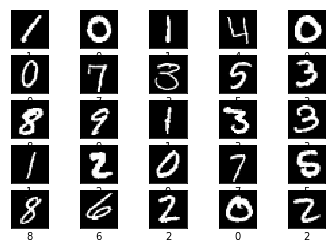

In [8]:
# What the digit image looks like
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(X_train.values.reshape(-1, 28,28, 1)[i][:,:,0], cmap='gray')
    plt.xlabel(Y_train[i])



In [9]:
# Label encoding
Y_train = to_categorical(Y_train)

In [10]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [11]:
# Split training and validate set
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Convolution Neural Network

<img src="https://i.imgur.com/AjQYgPv.png" alt="Demo Architecture" title="Figure 1" width="500" />

In [12]:
# Python optimisation variables
learning_rate = 0.0001
epochs = 10 # change it to 10 to increase the accuracy rate
BATCH_SIZE = 50

In [13]:
# declare the training data placeholders
x = tf.placeholder(tf.float32, [None, 784])
x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, 10])

In [14]:
w_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 9], stddev=0.01))
b_conv1 = tf.Variable(tf.constant(0.01, shape=[9]))

w_conv2 = tf.Variable(tf.truncated_normal([5, 5, 9, 16], stddev=0.01))
b_conv2 = tf.Variable(tf.constant(0.01, shape=[16]))

w_fc = tf.Variable(tf.truncated_normal([16 * 4 * 4, 10], stddev=0.01))
b_fc = tf.Variable(tf.constant(0.01, shape=[10]))

h_conv1 = tf.nn.relu(tf.nn.conv2d(x_reshaped, w_conv1, [1, 1, 1, 1], padding="VALID") + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, w_conv2, [1, 1, 1, 1], padding="VALID") + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

h_pool2_flat = tf.reshape(h_pool2, [-1, 256])

h_fc = tf.nn.softmax(tf.matmul(h_pool2_flat, w_fc) + b_fc)

p_y_given_x = h_fc

y_pred = tf.argmax(p_y_given_x, axis = 1)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=h_fc, labels=y))
#cost = tf.losses.softmax_cross_entropy(y, h_fc, reduction=tf.losses.Reduction.MEAN)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(h_fc, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [15]:
# Using the training and test sets from Kaggle

# Split training and validate set
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(y_train) / BATCH_SIZE)
    for epoch in range(epochs):
        # Split training and validate set
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
        avg_cost = 0
        for i in range(total_batch):
            x_batch = x_train[BATCH_SIZE*i:BATCH_SIZE*(i+1)]
            y_batch = y_train[BATCH_SIZE*i:BATCH_SIZE*(i+1)]
            _, c = sess.run([optimizer, cost], feed_dict={ x: x_batch, y: y_batch})
            avg_cost += c / total_batch
        test_acc = sess.run(accuracy, feed_dict={x: x_val, y: y_val})
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost), " test accuracy: {:.3f}".format(test_acc))
    
    print("\nTraining complete!")
    print(sess.run(accuracy, feed_dict={x: x_val, y: y_val}))
        
    

Epoch: 1 cost = 1.949  test accuracy: 0.869
Epoch: 2 cost = 1.600  test accuracy: 0.895
Epoch: 3 cost = 1.568  test accuracy: 0.909
Epoch: 4 cost = 1.553  test accuracy: 0.919
Epoch: 5 cost = 1.544  test accuracy: 0.925
Epoch: 6 cost = 1.536  test accuracy: 0.933
Epoch: 7 cost = 1.530  test accuracy: 0.936
Epoch: 8 cost = 1.525  test accuracy: 0.940
Epoch: 9 cost = 1.520  test accuracy: 0.944
Epoch: 10 cost = 1.516  test accuracy: 0.946

Training complete!
0.9457143


In [17]:
# Using MNIST from Tensorflow

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

with tf.Session() as sess:
# initialise the variables
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(mnist.train.labels) / BATCH_SIZE)
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size=BATCH_SIZE)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost), " test accuracy: {:.3f}".format(test_acc))
        #summary = sess.run(merged, feed_dict={x: mnist.test.images, y: mnist.test.labels})
        #writer.add_summary(summary, epoch)

    print("\nTraining complete!")
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 1 cost = 1.886  test accuracy: 0.801
Epoch: 2 cost = 1.667  test accuracy: 0.821
Epoch: 3 cost = 1.646  test accuracy: 0.833
Epoch: 4 cost = 1.634  test accuracy: 0.839
Epoch: 5 cost = 1.625  test accuracy: 0.848
Epoch: 6 cost = 1.618  test accuracy: 0.854
Epoch: 7 cost = 1.612  test accuracy: 0.860
Epoch: 8 cost = 1.607  test accuracy: 0.865
Epoch: 9 cost = 1.602  test accuracy: 0.868
Epoch: 10 cost = 1.598  test accuracy: 0.869

Training complete!
0.8695
